## Get data

In [30]:
import pandas as pd
import datetime

In [22]:
# Note:
# Data from 1900 to 1973 includes only earthquakes with magnitude > 6.5. 
# Data from 1974 to 2023 includes only earthquakes with magnitude > 5.5.

# Scrape the data
url = 'http://www2.ssn.unam.mx:8080/sismos-fuertes/'
df = pd.read_html(url)[0]

# Clean the data
df.columns = df.iloc[0]
df = df[1:]
df = df.drop(df.columns[0], axis=1)
df = df.rename(columns={'Fecha':'Date', 'Hora':'Time', 'Latitud':'Latitude', 'Longitud':'Longitude', 
                        'Profundidad (km)':'Depth (km)', 'Magnitud':'Magnitude', 'Localizaci&oacuten':'Localizacion',
                        'Fecha UTC':'Date UTC', 'Hora UTC':'Time UTC'})

In [23]:
df.head()

,Date,Time,Latitude,Longitude,Depth (km),Magnitude,Localizacion,Date UTC,Time UTC
1,2023-06-18,14:30:22,23.29,-108.55,5,6.4,"122 km al ESTE de SAN JOSE DEL CABO, BCS",2023-06-18,20:30:22
2,2023-04-03,20:11:59,16.01,-97.06,26,5.5,"17 km al NORTE de PUERTO ESCONDIDO, OAX",2023-04-04,02:11:59
3,2023-03-01,22:40:43,16.17,-94.53,98,5.8,"47 km al SURESTE de UNION HIDALGO, OAX",2023-03-02,04:40:43
4,2023-02-08,09:16:25,16.82,-86.56,18,5.5,"262 km al SURESTE de CHETUMAL, QR",2023-02-08,15:16:25
5,2022-12-11,08:31:32,17.1298,-100.627,24,6.0,"10 km al SUR de TECPAN, GRO",2022-12-11,14:31:32


## Get the probability distribution for eathquakes per year

In [24]:
from matplotlib import pyplot as plt
import numpy as np

In [25]:
df.loc[df['Magnitude'] == '~6.4', 'Magnitude'] = 6.4 # Fix a data value

In [31]:
def get_distribution(min_magnitude=6.5):
    """
    Gets the probability distribution of the number of earthquake that occur in a year in Mexico.
    
    Args:
        min_magnitude (float): Minimum earthquake magnitude to consider (default is 6.5).
        
    Returns:
        eq_distribution_norm (Pandas Series): The normalized probability distribution.
    """
    
    # Get only the earthquakes with a magnitude above min_magnitude
    df['Magnitude'] = df['Magnitude'].astype(float)
    strong_eq_df = df[ df['Magnitude'] > min_magnitude ].copy()

    # Get a "Year" column from the "Date" column
    strong_eq_df['Date'] = pd.to_datetime(strong_eq_df['Date'])
    strong_eq_df.loc[:, 'Year'] = strong_eq_df['Date'].dt.year
    current_year = datetime.datetime.now().year
    strong_eq_df = strong_eq_df[ strong_eq_df['Year'] < current_year ] # Remove the current year as it hasn't ended yet
    
    # Get the distribution
    eq_per_year = strong_eq_df.groupby('Year').count()['Magnitude'] # Get the earthquakes per year
    eq_distribution = eq_per_year.value_counts() # Get the absolute distribution
    eq_distribution_norm = eq_distribution / eq_distribution.sum() # Normalize the values (get the probability distribution)
    
    
    # Plot the distribution
    
    # Convert to list
    number_list = list(eq_distribution_norm.index)
    probabilities_list = list(eq_distribution_norm.values)
    
    # Plot the graph
    plt.style.use('seaborn') # Set the style
    plt.bar(number_list, probabilities_list, label=probabilities_list) 
    
    # Add and format the labels
    plt.xlabel("Number of Earthquakes with Magnitude > " + str(min_magnitude))
    plt.ylabel("Probability of Occurrence")
    plt.title("Number of Earthquakes per Year in Mexico Since 1900", fontsize=14)
    for i, v in enumerate(probabilities_list): # Add data labels
        plt.text(number_list[i], v+0.005, str(round(v,2)), ha='center')
    
    # Show the graph
    plt.show()
    
    return eq_distribution_norm

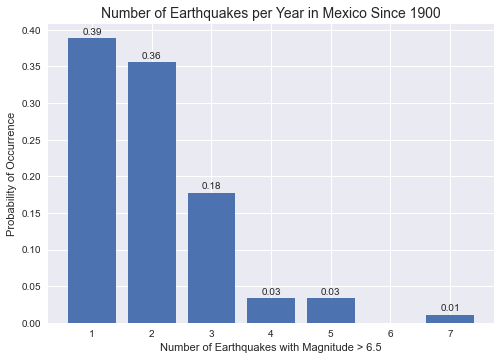

In [32]:
distribution = get_distribution()

## Simulation

In [33]:
def simulation(runs, years=37):
    """
    Simulate earthquake occurrences for a given number of runs and years.
    
    Args:
        runs (int): The number of simulation runs.
        years (int): The number of years per simulation run (default is 37).
        
    Returns:
        max_nums (dict): Probability distribution of the maximum number of earthquakes that occur on a single date within 
            the given period of time. The keys represent the number of earthquakes, and the values represent the probability
            of that number of earthquakes occurring.
    """
    max_nums = {}
    
    # For each run of the simulation
    for run in range(runs): 
        eq_days = {} # This dictionary will store the numbers of earthquakes for each calendar date
        
        # For each year
        for year in range(years):
            num_earthquakes = np.random.choice(distribution.index, p=distribution.values) # Randomly get the number of earthquakes in the year
            
            # For each earthquake
            for earthquake in range(num_earthquakes):
                eq_day = np.random.randint(low=1, high=366) # Randomly get the calendar date where the earthquake occured
                
                # Store the earthquake date
                if eq_day in eq_days:
                    eq_days[eq_day] += 1
                else:
                    eq_days[eq_day] = 1
                    
        max_num = max(eq_days.values()) # Number of earthquakes on the calendar date with the most earthquakes
        
        # Store the number of earthquakes on the calendar date with the most earthquakes
        if max_num in max_nums:
            max_nums[max_num] += 1
        else:
            max_nums[max_num] = 1
    
    # Normalize values in the distribution
    for key in max_nums:
        max_nums[key] = max_nums[key] / runs
        
    # Plot the distribution
    
    # Convert to list
    number_list = list(max_nums.keys())
    probabilities_list = max_nums.values()
    
    # Plot the graph
    plt.bar(max_nums.keys(), max_nums.values())
    
    # Add and format the labels
    plt.xlabel("Number of Earthquakes on the Maximum Date (in 37 years)", fontsize=14)
    plt.ylabel("Probability of Occurence")
    plt.title("Number of Earthquakes on Maximum Date", fontsize=14)
    plt.xticks(list(max_nums.keys()), [str(k) for k in max_nums.keys()]) #  Fix the x ticks
    for i, v in enumerate(probabilities_list): # Add data labels
        plt.text(number_list[i], v+0.005, str(round(v,2)), ha='center')
    
    # Show the graph
    plt.show()
        
    return max_nums

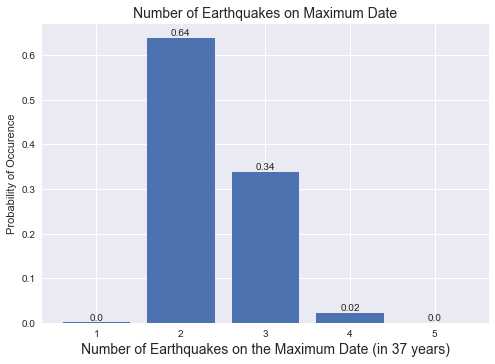

{2: 0.6387, 3: 0.338, 4: 0.0223, 1: 0.0007, 5: 0.0003}

In [35]:
simulation(10000)